# 8_Transfer_Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.data import Dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import EfficientNetB0, efficientnet

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

/opt/miniconda3/envs/computer_vision_project/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
RANDOM_SEED: int = 42

tf.random.set_seed(RANDOM_SEED)

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE: int = 16

In [ ]:
import tensorflow as tf
from pathlib import Path

CWD = Path.cwd()                       # .../computer_vision_project/data/Notebook
ROOT = CWD.parents[1]                  # .../computer_vision_project

IMG_DIR  = ROOT / "data" / "images"    # <--image folder
PROC_DIR = ROOT / "data" / "processed"
TRAIN_PATH = PROC_DIR / "train"
VAL_PATH   = PROC_DIR / "val"

print("CWD:", CWD)
print("ROOT:", ROOT)
print("IMG_DIR:", IMG_DIR, "exists?", IMG_DIR.exists())
print("Classes:", [p.name for p in IMG_DIR.iterdir() if p.is_dir()])

PROC_DIR.mkdir(parents=True, exist_ok=True)

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=str(IMG_DIR),
    labels="inferred",
    label_mode="int",
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="both",
    batch_size=None,
    pad_to_aspect_ratio=True,
)

train_ds.save(str(TRAIN_PATH))
val_ds.save(str(VAL_PATH))


CWD: /Users/azumimuhammed/Documents/computer_vision_project/data/Notebook
ROOT: /Users/azumimuhammed/Documents/computer_vision_project
IMG_DIR: /Users/azumimuhammed/Documents/computer_vision_project/data/images exists? True
Classes: ['A', 'C', 'B']
Found 690 files belonging to 3 classes.
Using 552 files for training.
Using 138 files for validation.


In [5]:
train_ds = tf.data.Dataset.load(str(TRAIN_PATH))
val_ds   = tf.data.Dataset.load(str(VAL_PATH))

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE*2).cache().prefetch(tf.data.AUTOTUNE)


### Multi-Part Models

Now that I have several different compontents to the model I can initialize them separately for better organization. The `name` parameter can help keep things organized.

In [43]:
IMG_SHAPE = (256, 256, 3)

In [44]:
# --- Image Augmentor ----
data_augmentor = keras.Sequential([
    # Randomized augmentations
    layers.RandomFlip("horizontal", seed=RANDOM_SEED),
    layers.RandomRotation(0.1, seed=RANDOM_SEED),
    layers.RandomContrast(factor=1, seed=RANDOM_SEED),
], name='augmentation_block')

Pretrained models often require specific preprocessing that may be different from the min max scaling. I will use keras preprocessors for these models ready to import and Lambda layer to turn that preprocessing into a keras layer so I can put it inside the pipeline.

In [45]:
# --- Preprocessor ---
# Preprocessing for EfficientNet architecture
preprocessor = layers.Lambda(efficientnet.preprocess_input, name='preprocessor')

In [46]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

CWD = Path.cwd()
ROOT = CWD.parents[1]  # repo root
WEIGHTS = ROOT / "models" / "efficientnetb0_notop.h5"

print("Weights path:", WEIGHTS, "exists?", WEIGHTS.exists())

feature_extractor = EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=str(WEIGHTS),
    name="efficientnet_backbone",
)

feature_extractor.trainable = False

Weights path: /Users/azumimuhammed/Documents/computer_vision_project/models/efficientnetb0_notop.h5 exists? True


In [47]:
# --- Classifier (also called "The Head") ---
classifier = keras.Sequential([

    # Flattening input
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),

    # Dense hidden layer with dropout
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(3, activation='softmax')
    
], name='classification_head')

In [48]:
# Combining the modules
model = keras.Sequential([
    layers.Input(shape=IMG_SHAPE),
    data_augmentor, #augmenting before scaling is more efficient
    preprocessor,
    feature_extractor,
    classifier
], name='full_pipeline')

model.summary()

Model: "full_pipeline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_block (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessor (Lambda)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet_backbone           │ (None, 8, 8, 1280)     │     4,049,571 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 3)              │       164,355 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Training

In [41]:
# Initializing early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=5, #number of epochs of no improvement before training is stopped
    restore_best_weights=True #revert weights back to what they were before the plateau (undo overfitting)
)

In [42]:
# Initializing AdamW with weight decay
adamw_optimizer = AdamW(
    learning_rate=1e-3, 
    weight_decay=1e-4, 
)

In [33]:
# Compile model with new optimizer
model.compile(
    optimizer=adamw_optimizer,
    loss='sparse_categorical_crossentropy', #for multiclass problems
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=60, #maximum epochs, may stop before this now that we have early stopping
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 479ms/step - accuracy: 0.4688 - loss: 1.0219 - val_accuracy: 0.8188 - val_loss: 0.6856
Epoch 2/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - accuracy: 0.7610 - loss: 0.6124 - val_accuracy: 0.8986 - val_loss: 0.4365
Epoch 3/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step - accuracy: 0.8327 - loss: 0.4595 - val_accuracy: 0.9275 - val_loss: 0.2908
Epoch 4/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.8658 - loss: 0.3528 - val_accuracy: 0.9348 - val_loss: 0.2041
Epoch 5/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.8787 - loss: 0.3177 - val_accuracy: 0.9638 - val_loss: 0.1674
Epoch 6/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - accuracy: 0.9062 - loss: 0.2590 - val_accuracy: 0.9493 - val_loss: 0.1656
Epoch 7/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.9191 - loss: 0.2214 - val_accuracy: 0.9420 - val_loss: 0.1428
Epoch 8/60
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.9467 - loss: 0.1983 - val_accuracy: 0

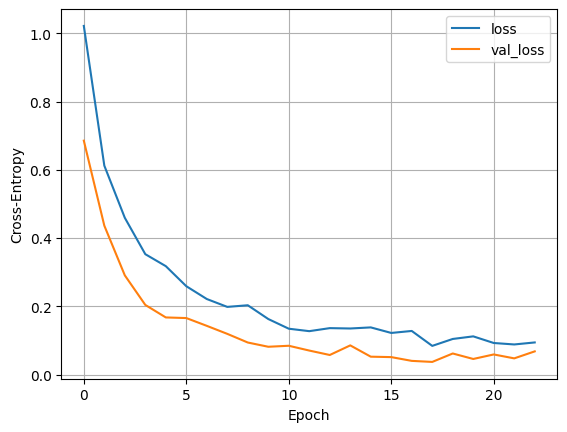

In [34]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.grid(True)

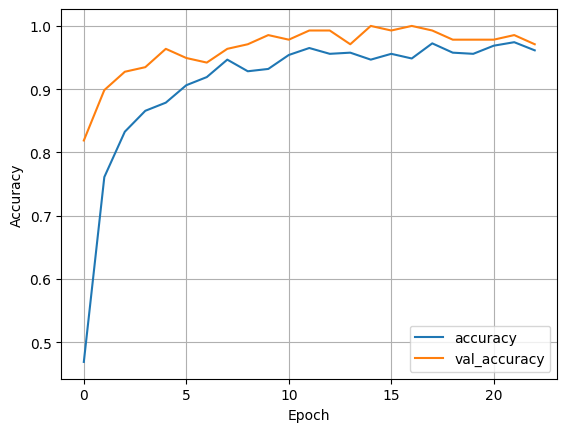

In [35]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [36]:
# Making predictions for the test set
test_probs: np.array = model.predict(val_ds)
# Converting probabilities into specific predictions
test_preds: np.array = np.argmax(test_probs, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step


In [37]:
# Extracting y_test

# Unpack batch labels from val_ds
y_test_batches: list[np.ndarray] = [y for x, y in val_ds]
# Concatonate batches
y_test: np.ndarray = np.concatenate(y_test_batches)

In [38]:
# Examining scores
class_names: list[str] = ['A', 'B', 'C']

print(classification_report(y_test, test_preds, target_names=class_names))

              precision    recall  f1-score   support

           A       1.00      0.98      0.99        53
           B       1.00      1.00      1.00        40
           C       0.98      1.00      0.99        45

    accuracy                           0.99       138
   macro avg       0.99      0.99      0.99       138
weighted avg       0.99      0.99      0.99       138



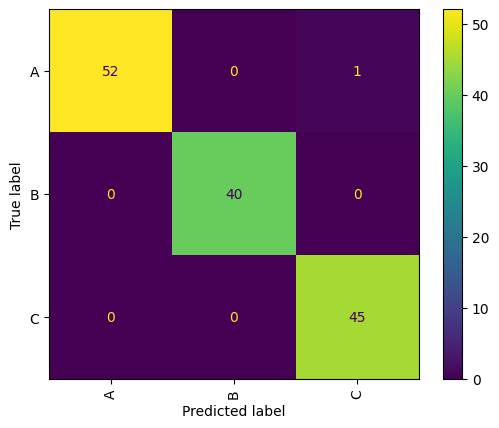

In [39]:
# Displaying confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=test_preds,
    display_labels=class_names,
    xticks_rotation='vertical'
);

The confusion matrix shows that the EfficientNetB0-based transfer learning model achieves 97.8% validation accuracy across three classes (A, B, C). Class B is classified perfectly, with no false positives or false negatives, indicating strong class separability. Minor confusion is observed only between classes A and C, with three total misclassifications, suggesting visual similarity rather than model error. Overall, the confusion matrix confirms robust feature extraction and strong generalization performance.

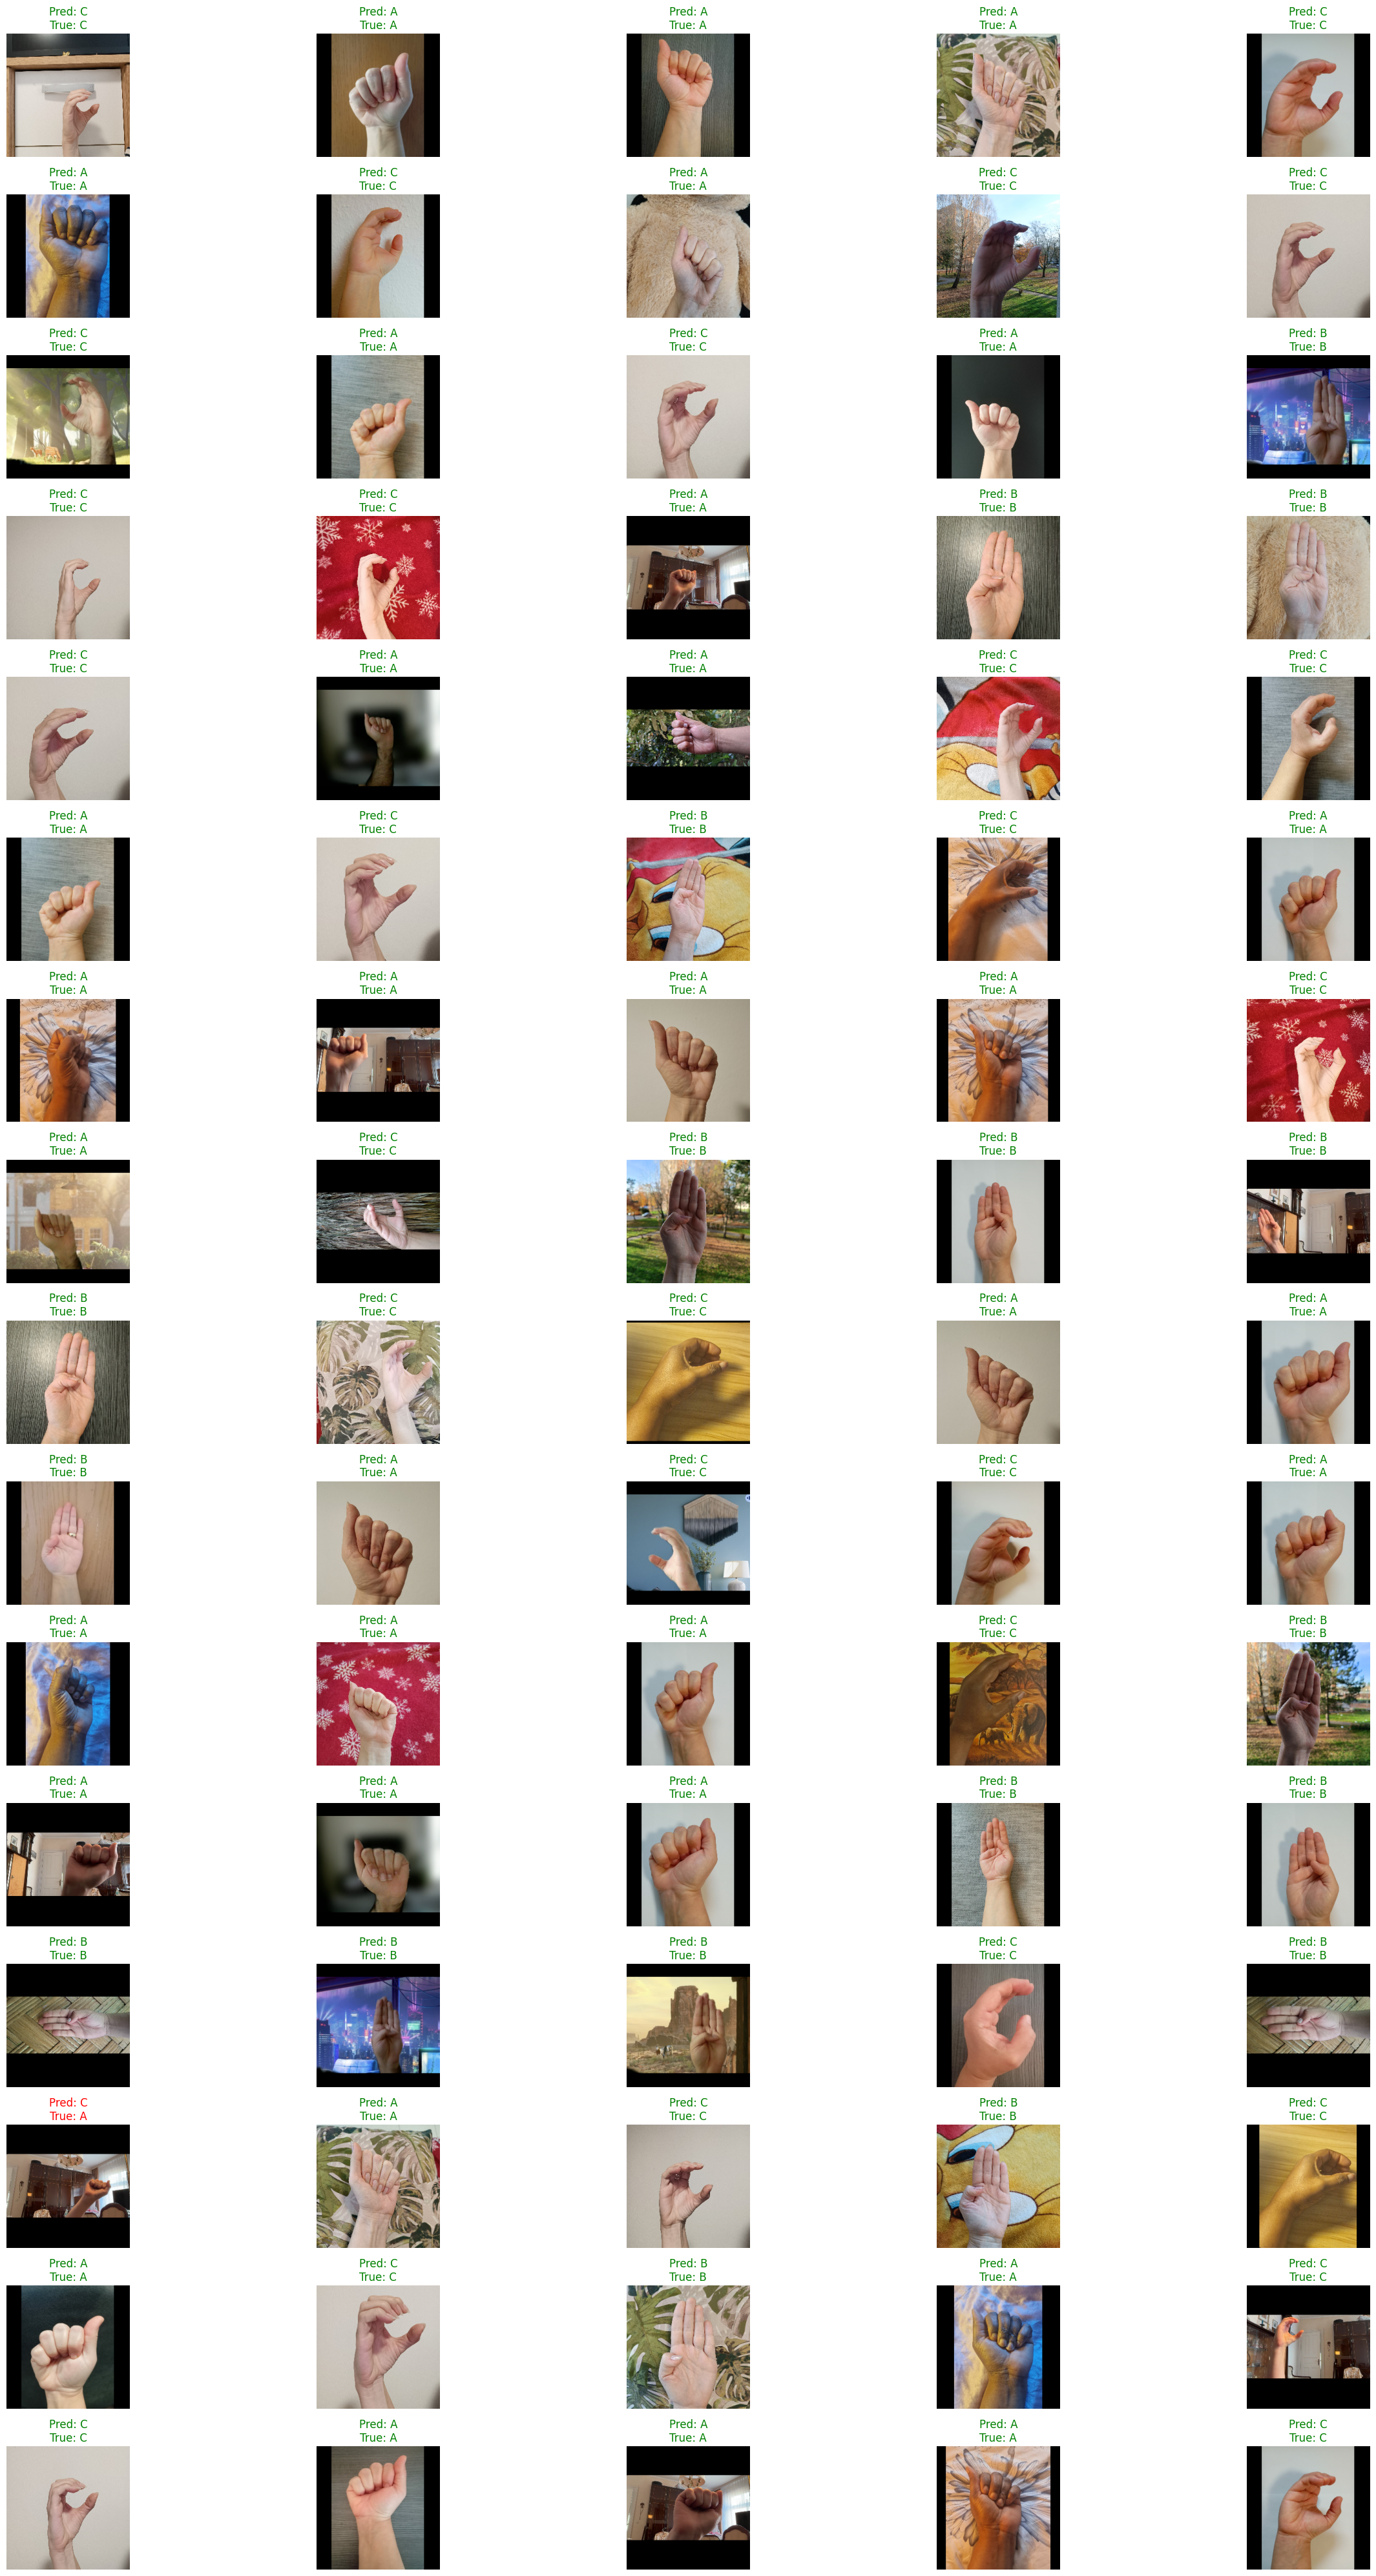

In [49]:
# Visualizing first 80 predictions
num_vis: int = 80

# Extracting images
batched_test_images: list[np.ndarray] = [X_batch for X_batch, y_batch in val_ds]
test_images: np.ndarray = np.concatenate(batched_test_images)

plt.figure(figsize=(int(num_vis/3),int(num_vis/2)))
columns=5

for i in range(num_vis):
    plt.subplot(int(num_vis/columns), columns, i+1)
    plt.imshow(test_images[i].astype('uint8'), cmap='gray')
    pred: int = test_preds[i]
    true: int = y_test[i]
    colour = 'green' if pred == true else 'red'
    plt.title(f'Pred: {class_names[pred]}\nTrue: {class_names[true]}', color=colour)
    plt.axis('off')

plt.tight_layout()
plt.show()